In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

#Crossvalidation and Batching

##Test Train Split - Vanilla case

In [ ]:
# Data prep
iris = sns.load_dataset("iris")
iris.head()

iris.species.drop_duplicates()

iris["species_num"] = np.where(iris.species=="setosa",0,np.where(iris.species=="versicolor",1,2))
iris[["species","species_num"]].value_counts()

data = iris[iris.columns[0:4]]
data.head()

data = torch.tensor(data.values).float()
data[0:5]

labels = torch.tensor(iris[iris.columns[5]].values)

print("data.shape",data.shape)
print("labels.shape",labels.shape)

data.shape torch.Size([150, 4])
labels.shape torch.Size([150])


In [ ]:
#test train split
popTraining = 0.8
nTraining = int(len(data)*popTraining)

#initialize boolean vector to select data and labels
traintestBool = np.zeros(len(data),dtype = bool)
traintestBool[range(nTraining)] = True

#randomly selecting train/test splits
items2train = np.random.choice(range(len(data)),nTraining,replace = False)
traintestBool = np.zeros(len(data),dtype = bool)
traintestBool[items2train] = True

#Balance of data
print("Average data",labels.float().mean())
print("Average training data",labels[traintestBool].float().mean())
print("Average test data",labels[~traintestBool].float().mean())

Average data tensor(1.)
Average training data tensor(0.9667)
Average test data tensor(1.1333)


training data.shape torch.Size([120, 4])
test data.shape torch.Size([30, 4])


Text(0.5, 1.0, 'Loss vs iterations')

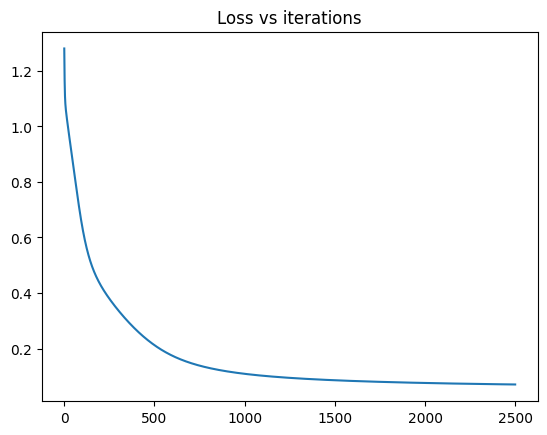

In [ ]:
ANNiris = nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3)

)

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNiris.parameters(),lr = 0.01)

print("training data.shape",data[traintestBool].shape)
print("test data.shape",data[~traintestBool].shape)

#training
numepochs = 2500
losses = torch.zeros(numepochs)
ongoingacc = []

trainingdata = data[traintestBool,:]
traininglabels = labels[traintestBool]


for epochi in range(numepochs):
  yhat = ANNiris(trainingdata)
  loss = lossfun(yhat,traininglabels)
  losses[epochi] = loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  acc = torch.mean((torch.argmax(yhat,axis = 1)==traininglabels).float())*100
  ongoingacc.append(acc)

plt.plot(losses.detach())
plt.title("Loss vs iterations")


test accuracy tensor(93.3333)
train accuracy tensor(99.1667)
train accuracy tensor(99.1667)


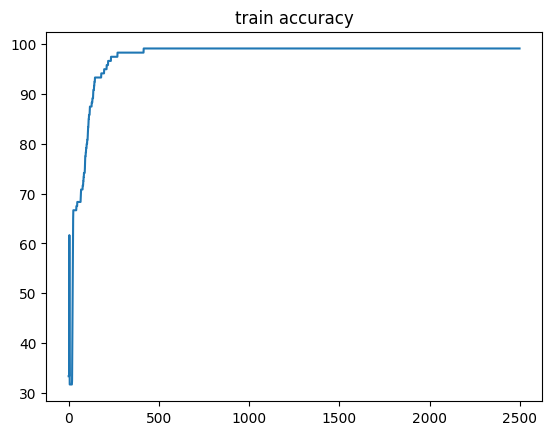

In [ ]:
plt.plot(ongoingacc)
plt.title("train accuracy")

##Test accuracy
yhat = ANNiris(data[~traintestBool,:])
acc = torch.mean((torch.argmax(yhat,axis = 1)==labels[~traintestBool]).float())*100
print("test accuracy",acc)

#Train data
yhat = ANNiris(trainingdata)
acc = torch.mean((torch.argmax(yhat,axis = 1)==traininglabels).float())*100
print("train accuracy",acc)
print("train accuracy",ongoingacc[-1])

##Test Train Split - Scikit Learn

In [ ]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, shuffle = True)

print(data_train.shape)
print(labels_train.shape)
print(data_test.shape)
print(labels_test.shape)

torch.Size([120, 4])
torch.Size([120])
torch.Size([30, 4])
torch.Size([30])


In [ ]:
#model initialization
def model_initialize():
  model = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3)

  )

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

  return model,lossfun,optimizer

#training
def training(trainProp,model,lossfun,optimizer,numepochs):
  data_train, data_test, labels_train, labels_test = train_test_split(data, labels, train_size = trainProp, shuffle = True)

  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  for epochi in range(numepochs):
    yhat = model(data_train)
    loss = lossfun(yhat,labels_train)
    losses[epochi] = loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    yhat_train = model(data_train)
    yhat_test = model(data_test)

    trainAcc.append(torch.mean((torch.argmax(yhat_train,axis = 1)==labels_train).float())*100)
    testAcc.append(torch.mean((torch.argmax(yhat_test,axis = 1)==labels_test).float())*100)

  return trainAcc,testAcc

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)
[tensor(35.8333), tensor(35.), tensor(34.1667), tensor(35.), tensor(37.5000), tensor(46.6667), tensor(56.6667), tensor(66.6667), tensor(67.5000), tensor(67.5000), tensor(67.5000), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3333), tensor(68.3

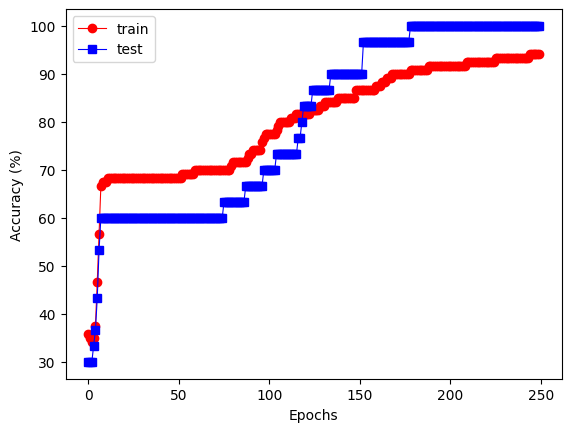

In [ ]:
numepochs = 250

model,lossfun,optimizer  = model_initialize()
print(model)

trainAcc,testAcc = training(0.8,model,lossfun,optimizer,numepochs)
print(trainAcc,testAcc)

plt.plot(trainAcc,'ro-',label = "train", linewidth=0.8)
plt.plot(testAcc,'bs-',label = "test", linewidth=0.8)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

In [ ]:
numepochs = 200
trainingSetSizes = np.linspace(0.2,0.95,10)
allTrainAcc = np.zeros((len(trainingSetSizes),numepochs))
allTestAcc = np.zeros((len(trainingSetSizes),numepochs))

for i in range(len(trainingSetSizes)):

  model,lossfun,optimizer  = model_initialize()

  trainAcc,testAcc = training(trainingSetSizes[i],model,lossfun,optimizer,numepochs)
  allTrainAcc[i,:] = trainAcc
  allTestAcc[i,:] = testAcc

/tmp/ipython-input-2435964587.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  allTrainAcc[i,:] = trainAcc
/tmp/ipython-input-2435964587.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  allTestAcc[i,:] = testAcc


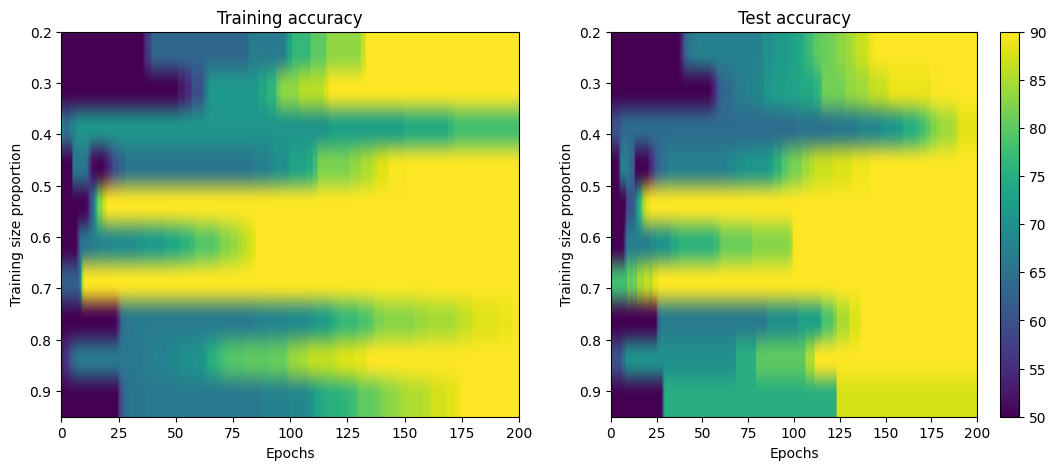

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (13,5))

ax[0].imshow(allTrainAcc,aspect ='auto',vmin=50,vmax=90,extent=[0,numepochs,trainingSetSizes[-1],trainingSetSizes[0]])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Training size proportion")
ax[0].set_title("Training accuracy")

p = ax[1].imshow(allTestAcc,aspect ='auto',vmin=50,vmax=90,extent=[0,numepochs,trainingSetSizes[-1],trainingSetSizes[0]])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training size proportion")
ax[1].set_title("Test accuracy")

fig.colorbar(p,ax = ax[1])

##Dataloader & Mini-Batches

In [ ]:
dummy_data = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
dummy_labels = np.arange(10)>4
print(dummy_data)
print(dummy_labels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
[False False False False False  True  True  True  True  True]


In [ ]:
dummy_dataLdr = DataLoader(dummy_data,shuffle = False)
print(dummy_dataLdr)
print(dummy_dataLdr.batch_size)

for i,onesample in enumerate(dummy_dataLdr):
  print(i,onesample,onesample.shape)

1
0 tensor([[11, 12, 13, 14]]) torch.Size([1, 4])
1 tensor([[21, 22, 23, 24]]) torch.Size([1, 4])
2 tensor([[31, 32, 33, 34]]) torch.Size([1, 4])
3 tensor([[41, 42, 43, 44]]) torch.Size([1, 4])
4 tensor([[51, 52, 53, 54]]) torch.Size([1, 4])
5 tensor([[61, 62, 63, 64]]) torch.Size([1, 4])
6 tensor([[71, 72, 73, 74]]) torch.Size([1, 4])
7 tensor([[81, 82, 83, 84]]) torch.Size([1, 4])
8 tensor([[91, 92, 93, 94]]) torch.Size([1, 4])
9 tensor([[101, 102, 103, 104]]) torch.Size([1, 4])


In [ ]:
consolidated_dataset = torch.utils.data.TensorDataset(torch.tensor(dummy_data),torch.tensor(dummy_labels).float())
print(consolidated_dataset)
print()

#viewing the tuples contained in the tensor dataset
for i in consolidated_dataset:
  print(i)
print()

consolidated_dataset.tensors


(tensor([11, 12, 13, 14]), tensor(0.))
(tensor([21, 22, 23, 24]), tensor(0.))
(tensor([31, 32, 33, 34]), tensor(0.))
(tensor([41, 42, 43, 44]), tensor(0.))
(tensor([51, 52, 53, 54]), tensor(0.))
(tensor([61, 62, 63, 64]), tensor(1.))
(tensor([71, 72, 73, 74]), tensor(1.))
(tensor([81, 82, 83, 84]), tensor(1.))
(tensor([91, 92, 93, 94]), tensor(1.))
(tensor([101, 102, 103, 104]), tensor(1.))



(tensor([[ 11,  12,  13,  14],
         [ 21,  22,  23,  24],
         [ 31,  32,  33,  34],
         [ 41,  42,  43,  44],
         [ 51,  52,  53,  54],
         [ 61,  62,  63,  64],
         [ 71,  72,  73,  74],
         [ 81,  82,  83,  84],
         [ 91,  92,  93,  94],
         [101, 102, 103, 104]]),
 tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]))

In [ ]:
dummy_dataLdr = DataLoader(consolidated_dataset,shuffle = False,batch_size = 4) #default batchsize = 1
print(dummy_dataLdr)
print(dummy_dataLdr.batch_size)

for i,onesample in enumerate(dummy_dataLdr):
  print(i,onesample)
  print()

4
0 [tensor([[11, 12, 13, 14],
        [21, 22, 23, 24],
        [31, 32, 33, 34],
        [41, 42, 43, 44]]), tensor([0., 0., 0., 0.])]

1 [tensor([[51, 52, 53, 54],
        [61, 62, 63, 64],
        [71, 72, 73, 74],
        [81, 82, 83, 84]]), tensor([0., 1., 1., 1.])]

2 [tensor([[ 91,  92,  93,  94],
        [101, 102, 103, 104]]), tensor([1., 1.])]



In [ ]:
print("data.shape",data.shape)
print("labels.shape",labels.shape)

data.shape torch.Size([150, 4])
labels.shape torch.Size([150])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data,labels, train_size = 0.8)
print("x_train.shape",x_train.shape)
print("x_test.shape",x_test.shape)
print("y_train.shape",y_train.shape)
print("y_test.shape",y_test.shape)

xy_train = TensorDataset(x_train,y_train)
xy_test = TensorDataset(x_test,y_test)

xy_test.tensors[1].shape

xy_train_dldr = DataLoader(xy_train,shuffle = True, batch_size = 12)
xy_test_dldr = DataLoader(xy_test, shuffle = True, batch_size = xy_test.tensors[0].shape[0]) #one single batch of test data

x_train.shape torch.Size([120, 4])
x_test.shape torch.Size([30, 4])
y_train.shape torch.Size([120])
y_test.shape torch.Size([30])


In [ ]:
#training
def training(xy_train_dldr,xy_test_dldr,model,lossfun,optimizer,numepochs):

  trainAcc = []
  testAcc = []

  for epochi in range(numepochs):

    #loop over training data batches
    batchAcc = []

    for x,y in xy_train_dldr:

      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(torch.mean((torch.argmax(yhat,axis = 1)==y).float())*100)

    trainAcc.append(np.mean(batchAcc))

    #test accuracy
    x,y = next(iter(xy_test_dldr))
    predlabels = model(x)
    testAcc.append(torch.mean(((torch.argmax(predlabels,axis = 1)==y).float())*100))

  return trainAcc,testAcc

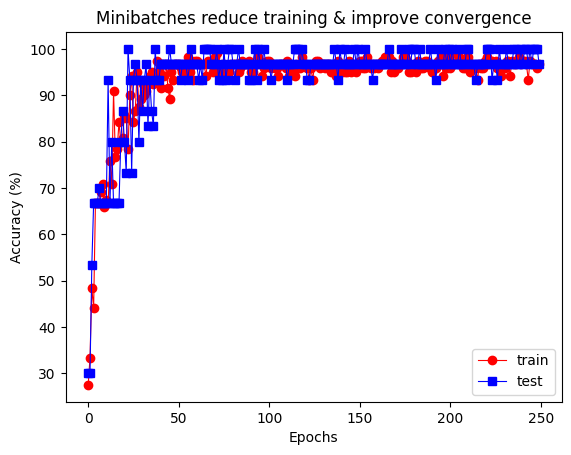

In [ ]:
model, lossfun, optimizer = model_initialize()
numepochs = 250
w,z  = training(xy_train_dldr,xy_test_dldr,model,lossfun,optimizer,numepochs)

plt.plot(w,'ro-',label = "train", linewidth=0.8)
plt.plot(z,'bs-',label = "test", linewidth=0.8)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Minibatches reduce training & improve convergence")
plt.legend()

##Test Train & Dev Sets

In [ ]:
#data creation
dummy_data = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
dummy_labels = np.arange(10)>4

#partition percentages for train, dev and test sets
partitions = [0.5,0.3,0.2]

#spliting data into train + temp
x_train, x_test_temp, y_train, y_test_tmp = train_test_split(dummy_data,dummy_labels,train_size = partitions[0])
print("x_train.shape",x_train.shape)
#print("x_test_temp.shape",x_test_temp.shape)
print("y_train.shape",y_train.shape)
#print("y_test_tmp.shape",y_test.shape)
print()

#splitting temp into dev and test
prop = partitions[1] / sum(partitions[1:])
x_dev,x_test,y_dev,y_test = train_test_split(x_test_temp,y_test_tmp,train_size = prop)
print("x_dev.shape",x_dev.shape)
print("y_dev.shape",y_dev.shape)
print()
print("x_test.shape",x_test.shape)
print("y_test.shape",y_test.shape)

x_train.shape (5, 4)
y_train.shape (5,)

x_dev.shape (3, 4)
y_dev.shape (3,)

x_test.shape (2, 4)
y_test.shape (2,)


#Regularization

## Dropout regularization

In [ ]:
# Drop out regularization and batch normalization are only applied during training data. (net.train())
# We do not apply these methods during testing. (net.eval(), torch.no_grad())
# Droput Regularization -randomly selected nodes droped during training i.e. activation set to 0.
# All nodes included (none dropped) during testing.
# Scaling issues can arise.
# Benefits - prevents any single node from learning too much/ too reliant on one node hence making the model more stable.
# Empirically - generally requires more training, though each iteration is faster due to fewer nodes; improves generalization ;
# Empirically - more effective on deep networks than shallow; works better with large data instead of small data.
# Image recognition - Drop out regularization has been known to improve accuracy of CNNs.
# Refrerence - Dropout: A Simple Way to Prevent Neural Networks from Overfitting https://jmlr.org/papers/v15/srivastava14a.html

In [ ]:
prob = 0.5 #default

dropout = nn.Dropout(p = prob)
x = torch.ones(10)

y = dropout(x)

print(x)
print(y) # values scaled up by 1/(1-p)
print(torch.mean(y))
print("sum",(y != 0).sum()) # Count non-zero elements after dropout

w, z = 0,0
for i in range(1000):
  y = dropout(x)
  z += torch.mean(y)
  w += (y != 0).sum()

print("mean",z)
print(w) #~ (1-p)*iterations = 0.2*1000 =2000


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 2., 2., 0., 0., 0., 0., 0., 2., 0.])
tensor(0.6000)
sum tensor(3)
mean tensor(1000.7999)
tensor(5004)


In [ ]:
#dropout is turned off during evaluation
prob = 0.5 #default
dropout = nn.Dropout(p = prob)

print("training")
dropout.train()
y = dropout(x)
print(y)
print(torch.mean(y))

print("\neval")
#turn off model learning
dropout.eval() #alternately, y = F.dropout(x,training = False)
y = dropout(x)
print(y)
print(torch.mean(y))

print("\nswitching back to training")
dropout.train()
y = dropout(x)
print(y)
print(torch.mean(y))

training
tensor([2., 2., 0., 2., 2., 2., 2., 0., 2., 0.])
tensor(1.4000)

eval
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)

switching back to training
tensor([0., 2., 2., 2., 0., 0., 2., 2., 0., 0.])
tensor(1.)


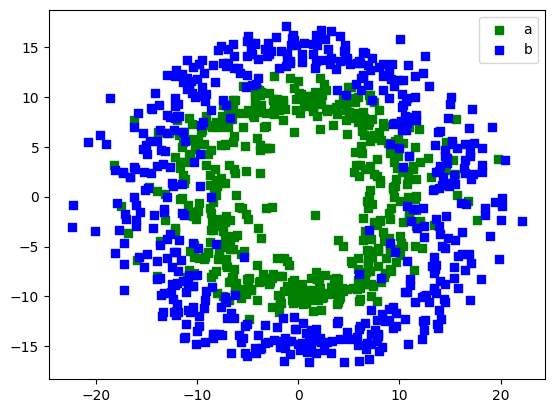

In [ ]:
# dataset creation
nPerClust =500

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [r1*np.cos(th) + np.random.randn(nPerClust)*3,
     r1*np.sin(th) + np.random.randn(nPerClust)]

b = [r2*np.cos(th) + np.random.randn(nPerClust)*3,
     r2*np.sin(th) + np.random.randn(nPerClust)]

data_np = np.hstack((a,b)).T
data = torch.tensor(data_np).float()

#true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
labels = torch.tensor(labels_np).float()

plt.scatter(a[0],a[1],label ="a",marker ="s",color = "green" )
plt.scatter(b[0],b[1],label ="b",marker ="s",color = "blue")
plt.legend()

In [ ]:
# train - test split
data_train, data_test, labels_train, labels_test = train_test_split(data,labels,train_size = 0.8)

print(data.shape)
print(data_train.shape)
print(data_test.shape)

print(labels.shape)
print(labels_train.shape)
print(labels_test.shape)

torch.Size([1000, 2])
torch.Size([800, 2])
torch.Size([200, 2])
torch.Size([1000, 1])
torch.Size([800, 1])
torch.Size([200, 1])


In [ ]:
# batching
dataset_train = TensorDataset(data_train,labels_train)
dataset_test = TensorDataset(data_test,labels_test)
dataset_train.tensors

batchsize = 16
train_dldr = DataLoader(dataset_train, batch_size = batchsize ,shuffle = True)
test_dldr = DataLoader(dataset_test, batch_size = dataset_test.tensors[0].shape[0] ,shuffle = True)

In [ ]:
class modelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    # layers
    self.input = nn.Linear(2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128,1)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # input layer
    x = F.relu(self.input(x))

    # dropout after input layer
    x = F.dropout(x, training = self.training, p = self.dr) #self.training is a boolean that is True when training, False when evaluating

    # hidden layer
    x = F.relu(self.hidden(x))

    # dropout after hidden layer
    x = F.dropout(x, training = self.training, p = self.dr)

    # output layer
    x = self.output(x)

    return x

In [ ]:
# test the model
model = modelClass(0.2)
print(model)

model(data_train[0:2])

modelClass(
  (input): Linear(in_features=2, out_features=128, bias=True)
  (hidden): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)


tensor([[-1.8541],
        [-1.5219]], grad_fn=<AddmmBackward0>)

In [ ]:
def model_initialize (dropoutRate):
  model = modelClass(dropoutRate)
  #lossfun = nn.CrossEntropyLoss()
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)

  return model,lossfun,optimizer

model,lossfun,optimizer = model_initialize(0.2)

In [ ]:
# model training
numepochs = 1000

def modelTraining(model,lossfun,optimizer,train_dldr,test_dldr):
  #print(numepochs)

  #initialize accuracies
  testAcc = []
  trainAcc = []

  testLoss = []
  trainLoss = []

  for i in range(numepochs):

    #switch training mode on
    model.train()

    batchAcc = []
    batchLoss = []
    for x,y in train_dldr:

      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(100*torch.mean(((yhat>0.5)==y).float()).item())
      batchLoss.append(loss)

    trainAcc.append(np.mean(batchAcc))
    #trainLoss.append(np.mean(batchLoss))

    # test accuracy
    model.eval() #switching off training

    for x,y in test_dldr:
      yhat = model(x)
      loss = lossfun(yhat,y)

      testAcc.append(100*torch.mean(((yhat>0.5)==y).float()).item())
      #testLoss.append(loss)

  return trainAcc, testAcc
  #, trainLoss, testLoss




In [ ]:
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode = 'same')

200


Text(0.5, 1.0, 'Dropout rate 0%')

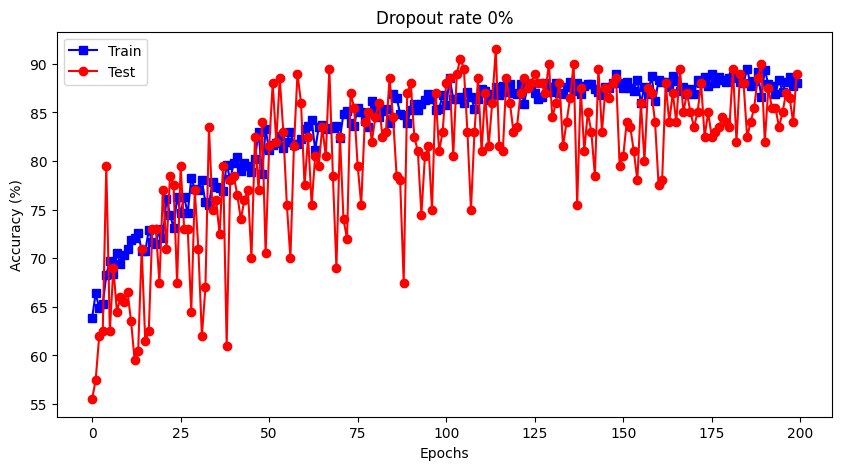

In [ ]:
fig = plt.figure(figsize = (10,5))

numepochs = 200
model,lossfun,optimizer = model_initialize(0)
trainAcc ,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train","Test"])
plt.title("Dropout rate 0%")

200


Text(0.5, 1.0, 'Dropout rate 0% (smoothed)')

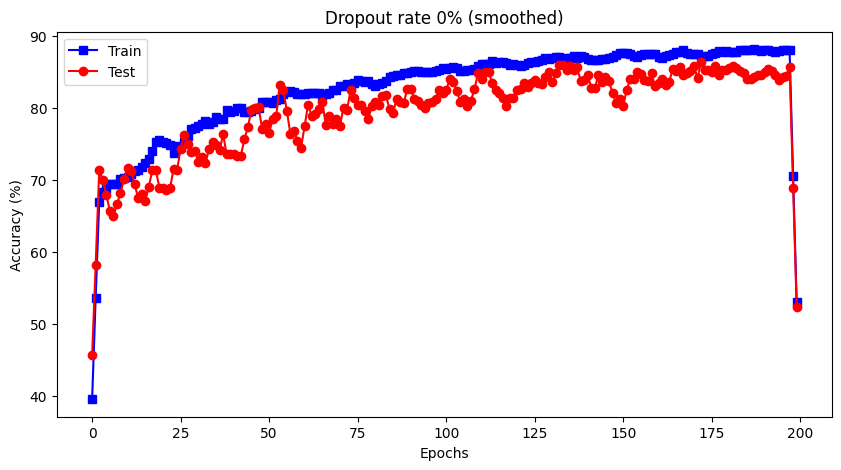

In [ ]:
fig = plt.figure(figsize = (10,5))

model,lossfun,optimizer = model_initialize(0)
trainAcc ,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train","Test"])
plt.title("Dropout rate 0% (smoothed)")

500
500


Text(0.5, 1.0, 'Dropout rate 0.5')

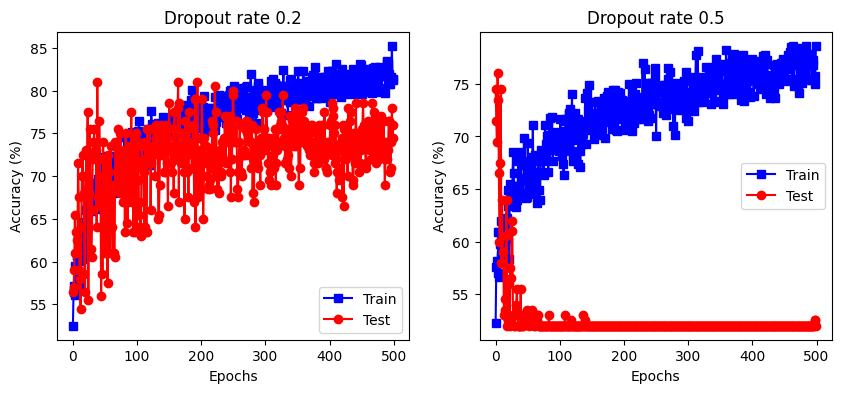

In [ ]:
numepochs = 500

fig,ax = plt.subplots(1,2,figsize = (10,4))

model,lossfun,optimizer = model_initialize(0.2)
trainAcc ,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

ax[0].plot(trainAcc,'bs-')
ax[0].plot(testAcc,'ro-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend(["Train","Test"])
ax[0].set_title("Dropout rate 0.2")

model,lossfun,optimizer = model_initialize(0.5)
trainAcc ,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

ax[1].plot(trainAcc,'bs-')
ax[1].plot(testAcc,'ro-')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend(["Train","Test"])
ax[1].set_title("Dropout rate 0.5")

In [ ]:
dropoutrates = np.arange(10)/10
print("dropout rates ",dropoutrates)

results = np.zeros((len(dropoutrates),2))
results.shape

for di in range(len(dropoutrates)):

  model,lossfun,optimizer = model_initialize(dropoutrates[di])
  trainAcc,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)
  results[di,0] , results[di,1] = np.mean(trainAcc[-100:]), np.mean(testAcc[-100:])

dropout rates  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


Text(0, 0.5, 'Train-test difference (acc%)')

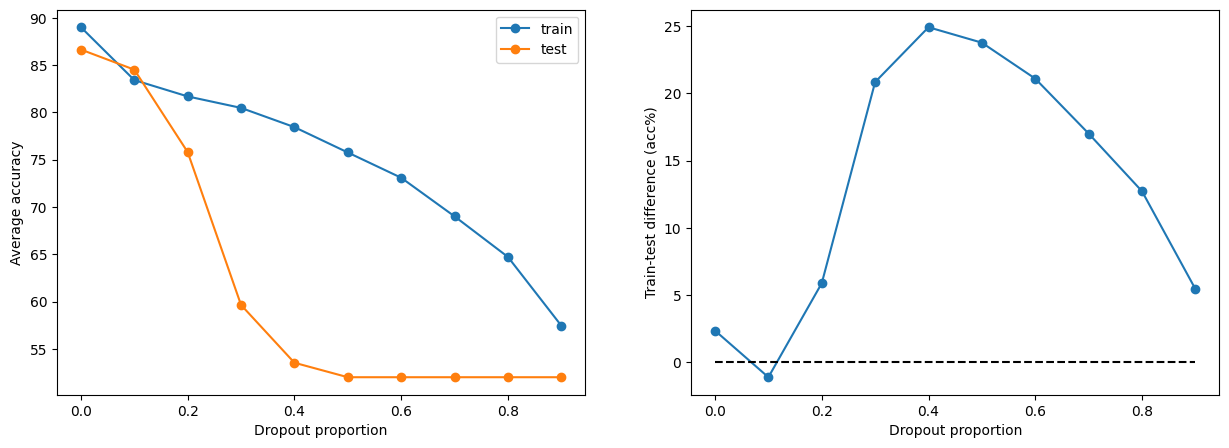

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(dropoutrates,results,'o-')
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(["train","test"])

ax[1].plot(dropoutrates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,0.9],[0,0],'k--')
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

Iris dataset

In [ ]:
# Data prep
iris = sns.load_dataset("iris")
iris.head()

iris.species.drop_duplicates()

iris["species_num"] = np.where(iris.species=="setosa",0,np.where(iris.species=="versicolor",1,2))
iris[["species","species_num"]].value_counts()

data = iris[iris.columns[0:4]]
data.head()

data = torch.tensor(data.values).float()
data[0:5]

labels = torch.tensor(iris[iris.columns[5]].values)

print("data.shape",data.shape)
print("labels.shape",labels.shape)

data.shape torch.Size([150, 4])
labels.shape torch.Size([150])


In [ ]:
data_train, data_test,labels_train, labels_test = train_test_split(data,labels,train_size=0.8)
print(data.shape)
print(data_train.shape)
print(data_test.shape)

print()
print(labels.shape)
print(labels_train.shape)
print(labels_test.shape)

torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])

torch.Size([150])
torch.Size([120])
torch.Size([30])


In [ ]:
train_dataset = TensorDataset(data_train,labels_train)
test_dataset = TensorDataset(data_test,labels_test)

train_dldr = DataLoader(train_dataset,batch_size = 16, shuffle = True)
test_dldr = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0], shuffle = True)

In [ ]:
class modelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    # layers
    self.input = nn.Linear(4,12)
    self.hidden = nn.Linear(12,12)
    self.output = nn.Linear(12,3)

    # parameters
    self.dr = dropoutRate

  # forward pass
  def forward(self,x):

    # input layer
    x = F.relu(self.input(x))

    # dropout after input layer
    x = F.dropout(x, training = self.training, p = self.dr) #self.training is a boolean that is True when training, False when evaluating

    # hidden layer
    x = F.relu(self.hidden(x))

    # dropout after hidden layer
    x = F.dropout(x, training = self.training, p = self.dr)

    # output layer
    x = self.output(x)

    return x

In [ ]:
def model_initialize (dropoutRate):
  model = modelClass(dropoutRate)
  lossfun = nn.CrossEntropyLoss()
  #lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.005)

  return model,lossfun,optimizer

model,lossfun,optimizer = model_initialize(0.2)
model

modelClass(
  (input): Linear(in_features=4, out_features=12, bias=True)
  (hidden): Linear(in_features=12, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=3, bias=True)
)

In [ ]:
# model training
numepochs = 500

def modelTraining(model,lossfun,optimizer,train_dldr,test_dldr):
  #print(numepochs)

  #initialize accuracies
  testAcc = []
  trainAcc = []

  #testLoss = []
  #trainLoss = []

  for i in range(numepochs):

    #switch training mode on
    model.train()

    batchAcc = []
    #batchLoss = []
    for x,y in train_dldr:

      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(100*torch.mean(((torch.argmax(yhat,axis=1))==y).float()).item())
      #batchLoss.append(loss)

    trainAcc.append(np.mean(batchAcc))
    #trainLoss.append(np.mean(batchLoss))

    # test accuracy
    model.eval() #switching off training

    for x,y in test_dldr:
      yhat = model(x)
      loss = lossfun(yhat,y)

      testAcc.append(100*torch.mean(((torch.argmax(yhat,axis=1))==y).float()).item())
      #testLoss.append(loss)

  return trainAcc, testAcc
  #, trainLoss, testLoss

Text(0.5, 1.0, 'Dropout rate 0%')

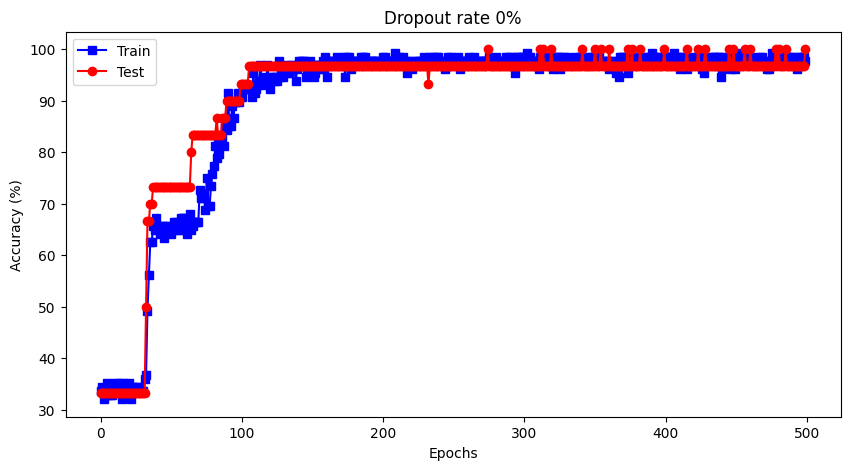

In [ ]:
model,lossfun,optimizer = model_initialize(0)
trainAcc, testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

fig = plt.figure(figsize = (10,5))

plt.plot(trainAcc,'bs-')
plt.plot(testAcc,'ro-')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train","Test"])
plt.title("Dropout rate 0%")

Text(0.5, 1.0, 'Dropout rate 0.5')

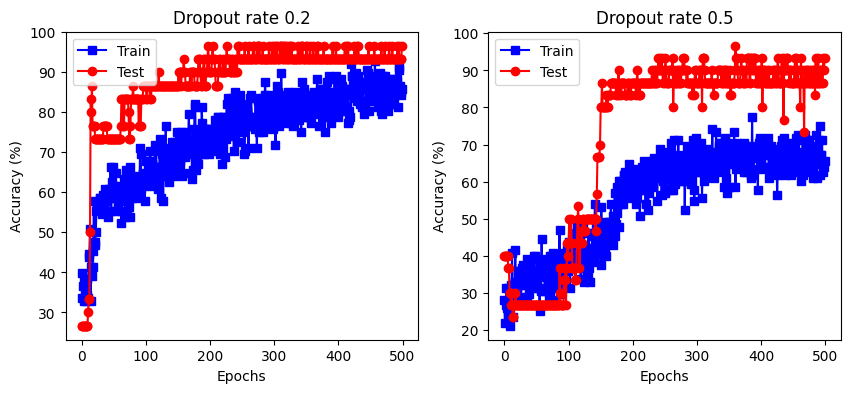

In [ ]:
numepochs = 500

fig,ax = plt.subplots(1,2,figsize = (10,4))

model,lossfun,optimizer = model_initialize(0.2)
trainAcc ,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

ax[0].plot(trainAcc,'bs-')
ax[0].plot(testAcc,'ro-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy (%)")
ax[0].legend(["Train","Test"])
ax[0].set_title("Dropout rate 0.2")

model,lossfun,optimizer = model_initialize(0.5)
trainAcc ,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

ax[1].plot(trainAcc,'bs-')
ax[1].plot(testAcc,'ro-')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend(["Train","Test"])
ax[1].set_title("Dropout rate 0.5")

In [ ]:
dropoutrates = np.arange(10)/10
print("dropout rates ",dropoutrates)

results = np.zeros((len(dropoutrates),2))
results.shape

for di in range(len(dropoutrates)):

  model,lossfun,optimizer = model_initialize(dropoutrates[di])
  trainAcc,testAcc = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)
  results[di,0] , results[di,1] = np.mean(trainAcc[-100:]), np.mean(testAcc[-100:])

dropout rates  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


Text(0, 0.5, 'Train-test difference (acc%)')

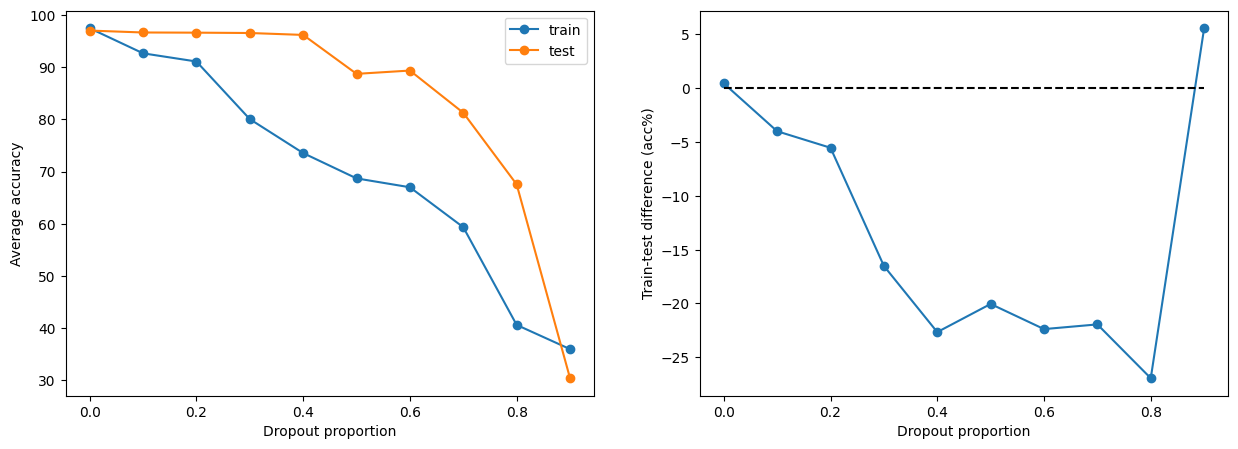

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(dropoutrates,results,'o-')
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Average accuracy")
ax[0].legend(["train","test"])

ax[1].plot(dropoutrates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,0.9],[0,0],'k--')
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

*Dropout regularization performs best for deeper models or where large data volumes are present. Shallow networks or small datasets do not benefit from dropout regularization*

## Loss regularization - L1 and L2

In [ ]:
# L1 / Lasso => Loss function (Regularized) = Loss function (original) + Regularization parameter(l) * ||w|| (L1-norm)
# L1 creates sparse weights by setting some weight values to 0.

# L2 / Ridge / Weight decay => Loss function (Regularized) = Loss function (original) + Regularization parameter(l) * ||w||^2 (L2-norm)
# L2 shrinks all weights, especially large weights. It does not reduce some weights to 0 like L1 regularization.

# Regularization reduces weights, value of l must be small and should not overpower the loss function else all weights will be pushed to 0.
# Regularization parameter can be selected based on domain knowledge,  literature review or emperically through cross validation.

# Benefits of regularization - improves generalizability, numerical stability and prevents overfitting.
# Numerical stability is established by reducing values of large weights. Very large weights can over influence multiplications causing unstable systems.

# Regularization is typically used for large, complex models or when faced with ill-conditioned problems.
# If there is evidence of overfitting then regularization techniques may also be explored. (Train accuracy >>> test accuracy)
# L1 may be used for feature selection, L2 is more commonly used in DL applications.

In [ ]:
# Iris dataset
iris = sns.load_dataset("iris")
iris.head()

iris.species.drop_duplicates()

iris["species_num"] = np.where(iris.species=="setosa",0,np.where(iris.species=="versicolor",1,2))
iris[["species","species_num"]].value_counts()

data = iris[iris.columns[0:4]]
data.head()

data = torch.tensor(data.values).float()
data[0:5]

labels = torch.tensor(iris[iris.columns[5]].values)

print("data.shape",data.shape)
print("labels.shape",labels.shape)

data_train, data_test,labels_train, labels_test = train_test_split(data,labels,train_size=0.8)
print(data.shape)
print(data_train.shape)
print(data_test.shape)

print()
print(labels.shape)
print(labels_train.shape)
print(labels_test.shape)

train_dataset = TensorDataset(data_train,labels_train)
test_dataset = TensorDataset(data_test,labels_test)

train_dldr = DataLoader(train_dataset,batch_size = 16, shuffle = True)
test_dldr = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0], shuffle = True)

data.shape torch.Size([150, 4])
labels.shape torch.Size([150])
torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])

torch.Size([150])
torch.Size([120])
torch.Size([30])


L2 Regularization

In [ ]:
def createModel(L2lambda):
  model = nn.Sequential(
      nn.Linear(4,64),
      nn.ReLU(),
      nn.Linear(64,64),
      nn.ReLU(),
      nn.Linear(64,3) )

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model.parameters(),lr = 0.005, weight_decay = L2lambda )

  return model,lossfun,optimizer

In [ ]:
# model training
numepochs = 500

def modelTraining(model,lossfun,optimizer,train_dldr,test_dldr):
  #print(numepochs)

  #initialize accuracies
  testAcc = []
  trainAcc = []
  losses = []

  for i in range(numepochs):

    #switch training mode on
    model.train()

    batchAcc = []
    batchLoss = []
    for x,y in train_dldr:

      yhat = model(x)
      loss = lossfun(yhat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(100*torch.mean(((torch.argmax(yhat,axis=1))==y).float()).item())
      batchLoss.append(loss.item())

    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    # test accuracy
    model.eval() #switching off training # turns off dropout regularization and batch normalization

    for x,y in test_dldr:
      yhat = model(x)
      loss = lossfun(yhat,y)

      testAcc.append(100*torch.mean(((torch.argmax(yhat,axis=1))==y).float()).item())
      #testLoss.append(loss)

  return trainAcc, testAcc,losses
  #, trainLoss, testLoss

In [ ]:
numepochs = 500
L2lambda = 0.01

model,lossfun,optimizer = createModel(L2lambda)
print(model)

trainAcc, testAcc, losses = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2764318596.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title("loss with L2 $\lambda$="+str(L2lambda))
/tmp/ipython-input-2764318596.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title("accuracy with L2 $\lambda$="+str(L2lambda))


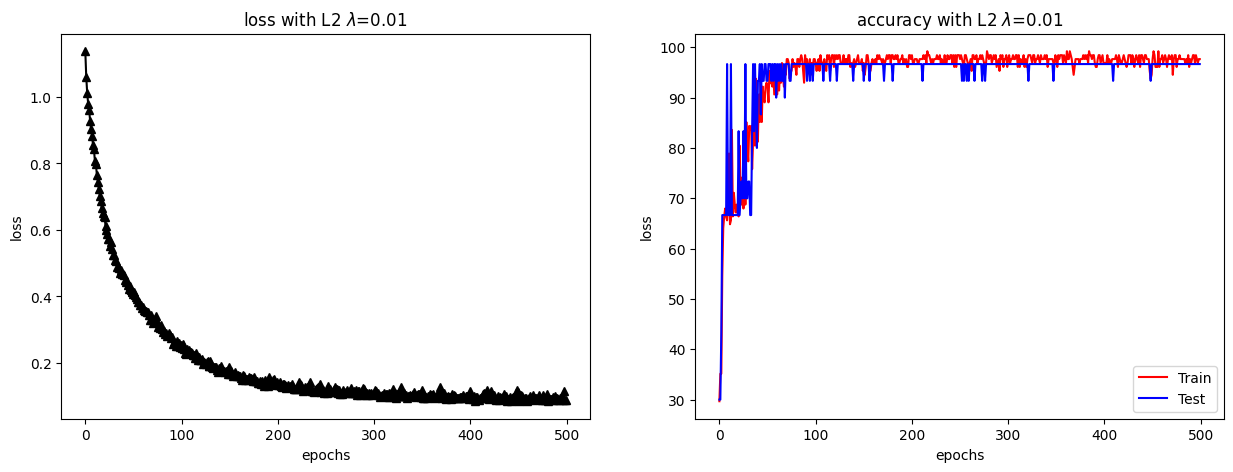

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(losses,"k^-")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title("loss with L2 $\lambda$="+str(L2lambda))

ax[1].plot(trainAcc,"r-")
ax[1].plot(testAcc,"b-")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("accuracy with L2 $\lambda$="+str(L2lambda))
ax[1].legend(["Train","Test"])

In [ ]:
l2lambdas = np.linspace(0,0.1,10)
print(l2lambdas)

numepochs = 1000
trainAcc = np.zeros((len(l2lambdas),numepochs))
testAcc = np.zeros((len(l2lambdas),numepochs))
losses = np.zeros((len(l2lambdas),numepochs))
print(trainAcc.shape)

for li,L2lambda in enumerate(l2lambdas):
  model,lossfun,optimizer = createModel(L2lambda)
  x,y,z = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr)
  trainAcc[li,:], testAcc[li,:], losses[li,:] = x,y,z

[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1       ]
(10, 1000)


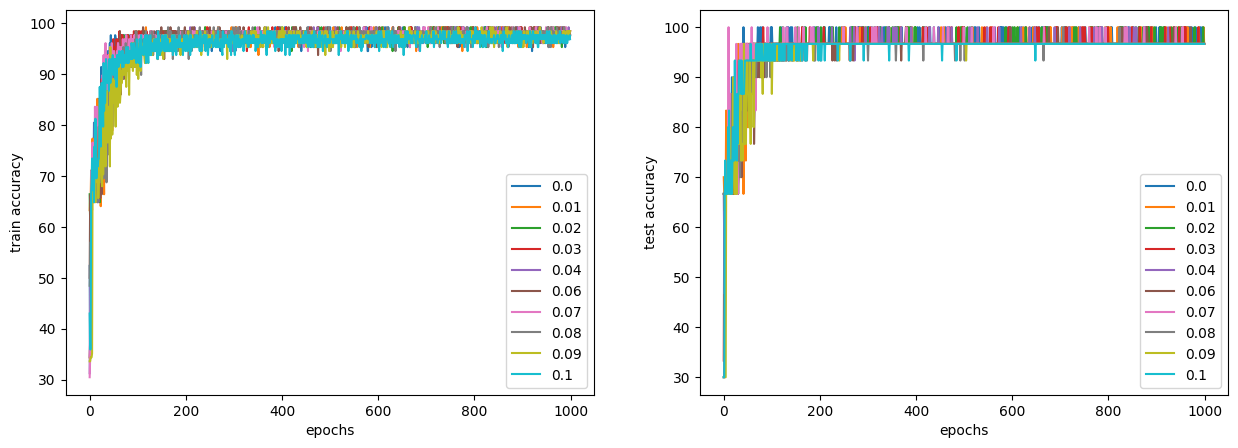

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
leglabels = [np.round(i,2) for i in l2lambdas]

ax[0].plot(trainAcc.T)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("train accuracy")
ax[0].legend(leglabels)
#ax[0].set_ylim([50,101])


ax[1].plot(testAcc.T)
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("test accuracy")
ax[1].legend(leglabels)


Text(0, 0.5, 'Accuracy')

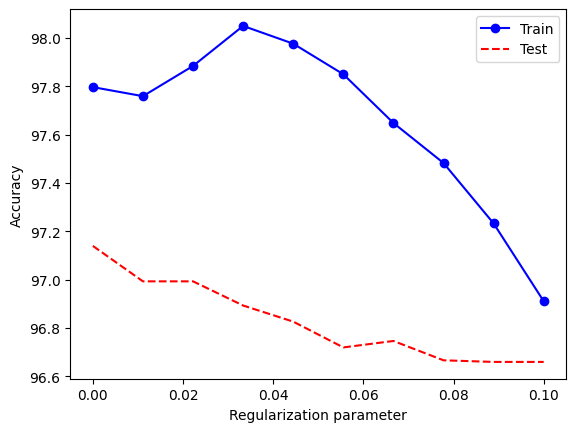

In [ ]:
plt.plot(l2lambdas,np.mean(trainAcc[:,500:],axis =1),"bo-")
plt.plot(l2lambdas,np.mean(testAcc[:,500:],axis =1),"r--")
plt.legend(["Train","Test"])
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy")

L1 Regularization

In [ ]:
L2lambda = 0
model,lossfun,optimizer = createModel(L2lambda)

In [ ]:
for i in model.named_parameters():
  print(i[0],i[1].shape,i[1].numel())

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [ ]:
# model training
numepochs = 500

def modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda):
  #print(numepochs)

  #initialize accuracies
  testAcc = []
  trainAcc = []
  losses = []

  #counting model weights
  nweights = 0
  for pname, weight in model.named_parameters():
    if "bias" not in pname:
      nweights += weight.numel()


  for i in range(numepochs):

    #switch training mode on
    model.train()

    batchAcc = []
    batchLoss = []
    for x,y in train_dldr:

      yhat = model(x)
      loss = lossfun(yhat,y)

      # adding L1 term
      L1_term = torch.tensor(0.0,requires_grad= True) #imp to turn requires grad to True to facilitate training

      for pname,weight in model.named_parameters():
        if "bias" not in pname:
          L1_term = L1_term + torch.sum(torch.abs(weight))

      # adding L1 penalty to loss
      loss = loss + L1lambda*L1_term/nweights

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchAcc.append(100*torch.mean(((torch.argmax(yhat,axis=1))==y).float()).item())
      batchLoss.append(loss.item())

    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    # test accuracy
    model.eval() #switching off training # turns off dropout regularization and batch normalization

    for x,y in test_dldr:
      yhat = model(x)
      loss = lossfun(yhat,y)

      testAcc.append(100*torch.mean(((torch.argmax(yhat,axis=1))==y).float()).item())
      #testLoss.append(loss)

  return trainAcc, testAcc,losses
  #, trainLoss, testLoss

In [ ]:
L2lambda = 0
numepochs = 500
L1lambda = 0.01

model,lossfun,optimizer = createModel(L2lambda)
trainAcc, testAcc,losses  = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1588266474.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_title("loss with L1 $\lambda$="+str(L1lambda))
/tmp/ipython-input-1588266474.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax[1].set_title("accuracy with L1 $\lambda$="+str(L1lambda))


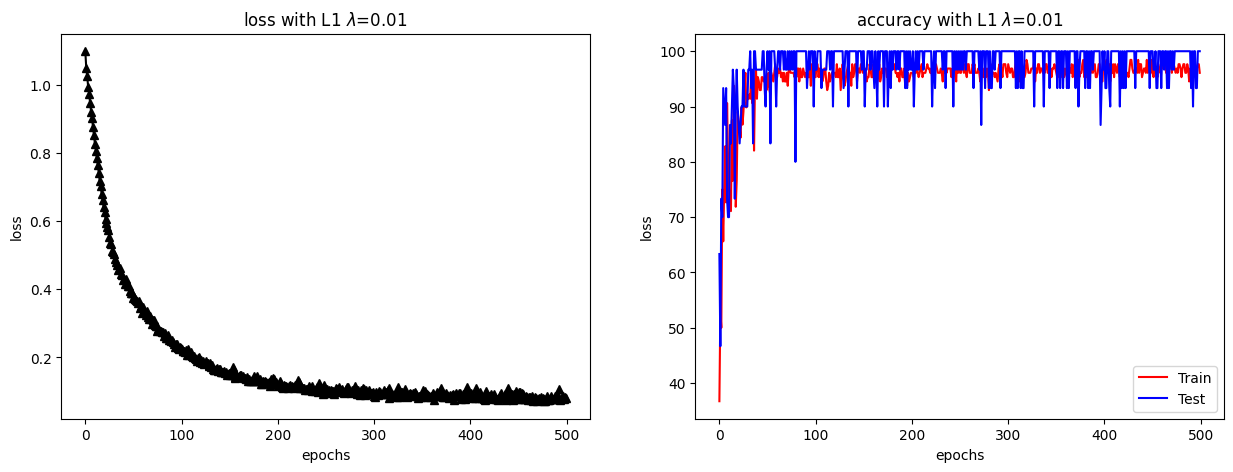

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(losses,"k^-")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title("loss with L1 $\lambda$="+str(L1lambda))

ax[1].plot(trainAcc,"r-")
ax[1].plot(testAcc,"b-")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss")
ax[1].set_title("accuracy with L1 $\lambda$="+str(L1lambda))
ax[1].legend(["Train","Test"])

In [ ]:
l1lambdas = np.linspace(0,0.1,10)
print(l1lambdas)

numepochs = 500
trainAcc = np.zeros((len(l1lambdas),numepochs))
testAcc = np.zeros((len(l1lambdas),numepochs))
losses = np.zeros((len(l1lambdas),numepochs))
print(trainAcc.shape)

for li,L1lambda in enumerate(l1lambdas):
  model,lossfun,optimizer = createModel(0)
  x,y,z = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda)
  trainAcc[li,:], testAcc[li,:], losses[li,:] = x,y,z

[0.         0.01111111 0.02222222 0.03333333 0.04444444 0.05555556
 0.06666667 0.07777778 0.08888889 0.1       ]
(10, 500)


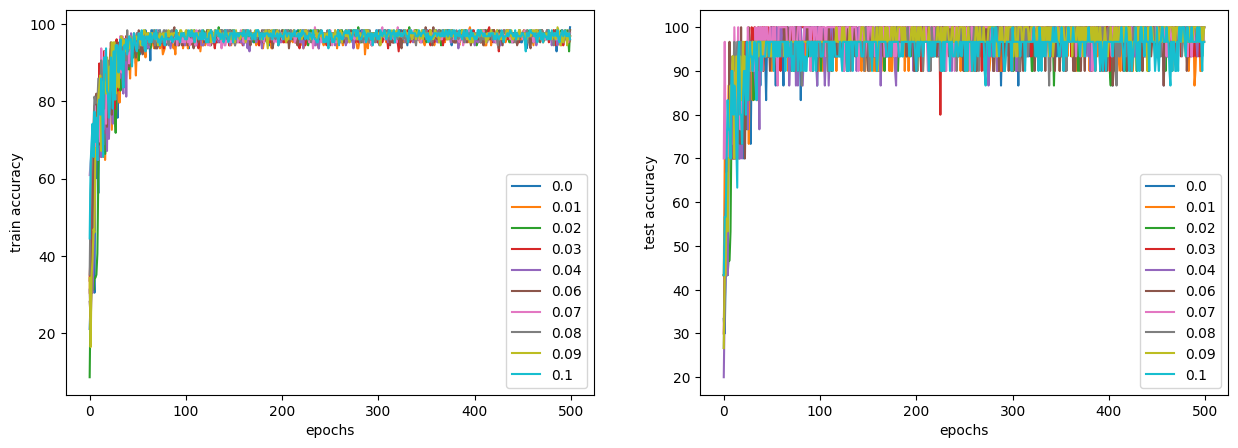

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
leglabels = [np.round(i,2) for i in l1lambdas]

ax[0].plot(trainAcc.T)
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("train accuracy")
ax[0].legend(leglabels)
#ax[0].set_ylim([50,101])


ax[1].plot(testAcc.T)
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("test accuracy")
ax[1].legend(leglabels)


Text(0, 0.5, 'Accuracy')

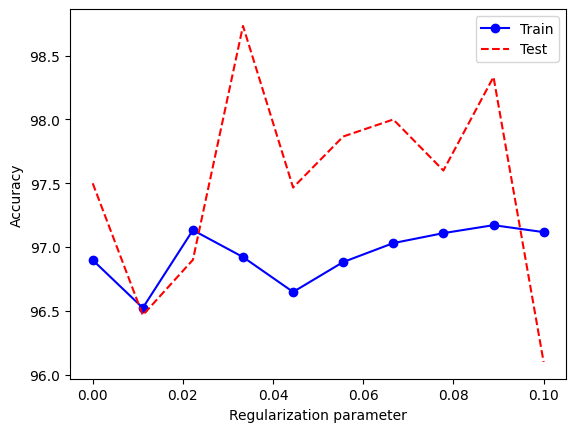

In [ ]:
plt.plot(l1lambdas,np.mean(trainAcc[:,400:],axis =1),"bo-")
plt.plot(l1lambdas,np.mean(testAcc[:,400:],axis =1),"r--")
plt.legend(["Train","Test"])
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy")

## Batchsize and training performance

In [ ]:
# Iris dataset
iris = sns.load_dataset("iris")
iris.head()

iris.species.drop_duplicates()

iris["species_num"] = np.where(iris.species=="setosa",0,np.where(iris.species=="versicolor",1,2))
iris[["species","species_num"]].value_counts()

data = iris[iris.columns[0:4]]
data.head()

data = torch.tensor(data.values).float()
data[0:5]

labels = torch.tensor(iris[iris.columns[5]].values)

print("data.shape",data.shape)
print("labels.shape",labels.shape)

data_train, data_test,labels_train, labels_test = train_test_split(data,labels,train_size=0.8)
print(data.shape)
print(data_train.shape)
print(data_test.shape)

print()
print(labels.shape)
print(labels_train.shape)
print(labels_test.shape)

train_dataset = TensorDataset(data_train,labels_train)
test_dataset = TensorDataset(data_test,labels_test)

train_dldr = DataLoader(train_dataset,batch_size = 16, shuffle = True, drop_last=True)
test_dldr = DataLoader(test_dataset,batch_size = test_dataset.tensors[0].shape[0], shuffle = True) #typically never partitioned into batches

data.shape torch.Size([150, 4])
labels.shape torch.Size([150])
torch.Size([150, 4])
torch.Size([120, 4])
torch.Size([30, 4])

torch.Size([150])
torch.Size([120])
torch.Size([30])


In [ ]:
for x,y in train_dldr:
  print(x.shape,y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


no.of batches = 1; batchsize = 120
no.of batches = 7; batchsize = 16
no.of batches = 30; batchsize = 4
no.of batches = 120; batchsize = 1


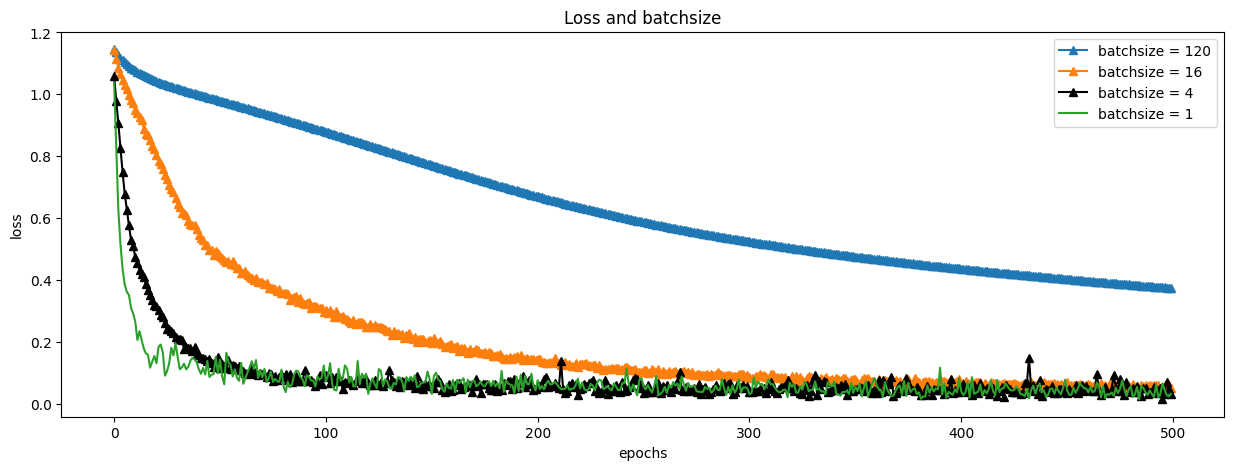

In [ ]:
numepochs = 500
L2lambda = 0
L1lambda = 0

fig = plt.figure(figsize = (15,5))

batchsize = 120
train_dldr = DataLoader(train_dataset,batch_size = batchsize, shuffle = True, drop_last=True)
model,lossfun,optimizer = createModel(L2lambda)
trainAcc, testAcc, losses = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda)

a = 0
for i in train_dldr:
  a +=1
print(f"no.of batches = {a}; batchsize = {batchsize}")

plt.plot(losses,"^-",label = "batchsize = 120")

batchsize = 16
train_dldr = DataLoader(train_dataset,batch_size = batchsize, shuffle = True, drop_last=True)
model,lossfun,optimizer = createModel(L2lambda)
trainAcc, testAcc, losses = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda)

a = 0
for i in train_dldr:
  a +=1
print(f"no.of batches = {a}; batchsize = {batchsize}")

plt.plot(losses,"^-",label = "batchsize = 16")

batchsize = 4
train_dldr = DataLoader(train_dataset,batch_size = batchsize, shuffle = True, drop_last=True)
model,lossfun,optimizer = createModel(L2lambda)
trainAcc, testAcc, losses = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda)

a = 0
for i in train_dldr:
  a +=1
print(f"no.of batches = {a}; batchsize = {batchsize}")

plt.plot(losses,"k^-", label = "batchsize = 4")

batchsize = 1
train_dldr = DataLoader(train_dataset,batch_size = batchsize, shuffle = True, drop_last=True)
model,lossfun,optimizer = createModel(L2lambda)
trainAcc, testAcc, losses = modelTraining(model,lossfun,optimizer,train_dldr,test_dldr,L1lambda)

a = 0
for i in train_dldr:
  a +=1
print(f"no.of batches = {a}; batchsize = {batchsize}")

plt.plot(losses,"-",label = "batchsize = 1")

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss and batchsize")
plt.legend()

*For this data and architecture, training is sped up by increasing the number of batches*

#Summary

*  Overfitting essentially limits our ability to generalize over unseen data

*  Underfitting occurs when a mathematical model cannot adequately capture the underlying structure of the data.

*  An under-fitted model is a model that is missing some parameters or terms that would appear in a correctly specified model

*  How is overfitting identified/avoided - low dimensional space (visualization) ; higher dimensional space (cross validation); regularization techniques

* Data = Training set + Hold out set + Test set

* Crucial assumption of cross validation - hold out & test set must be uncorrelated/independent/orthogonal with training set

* Batching improves training performace by reaching the desired accuracy in fewer iterations

* Regularization is a process that converts the answer to a problem to a simpler one. It is often used in solving ill-posed problems or to prevent overfitting.

* Regularization methods - modify model (drop out), add a cost to loss function (L1/2 regularization) OR modify/add data (batch training, data augmentation)

* Drop out - exclude nodes during training.

* A cost to the loss function prevents weights from becoming too large.

* Data augmentation is a technique to increase dataset diversity by applying transformations like rotation, flipping, cropping, and brightness adjustments without collecting new data. It is widely used in deep learning to improve model generalization.



